In [2]:
import xarray as xr
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, glob, re, time, math, calendar

# import custom functions
sys.path.append('/')
from libraries import *
from plotters import *

In [12]:
station_id = 'PROF_QUEE'

profiler_ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/{station_id}.nc')
profiler_data = profiler_ds.wind_speed.sel(range=slice(10,500),time=slice('2018-01-01T00',f'2020-12-31T23'))
profiler_z = profiler_ds.range.values

filtered_profiler_data = profiler_data.where(profiler_data.notnull().all(dim='range'), drop=True)
filtered_profiler_data

<xarray.DataArray 'wind_speed' (range: 18, time: 14504)> Size: 1MB
array([[4.1715326, 5.5637856, 0.76636  , ..., 4.091705 , 4.0266438,
        4.0207353],
       [6.0099096, 7.926126 , 1.5207922, ..., 6.139818 , 6.0570507,
        6.396818 ],
       [5.6687365, 7.9230356, 1.5449271, ..., 6.231348 , 6.285036 ,
        6.4305573],
       ...,
       [5.9158154, 8.626165 , 1.1848912, ..., 6.858288 , 6.3066225,
        7.1779833],
       [5.8177514, 8.624865 , 1.8151419, ..., 7.0409174, 6.3455915,
        7.1476736],
       [5.7222958, 8.712404 , 2.4211864, ..., 7.1791   , 6.3081174,
        7.1335354]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 116kB 2018-01-02T20:00:00 ... 2020-12-31T2...
  * range    (range) int64 144B 10 100 125 150 175 200 ... 400 425 450 475 500
    station  <U9 36B 'PROF_QUEE'

In [32]:
NOW23_z = np.array([10] + list(range(20, 301, 20)) + [400, 500])

dfs = []
for year in range(2018,2021):
    df = pd.read_csv(f'data/NOW23/{station_id}/{year}.csv',index_col=0)
    df.index = pd.to_datetime(df.index)
    dfs.append(df)
combined_df = pd.concat(dfs,axis=0)

NOW23_ds = xr.Dataset(
    data_vars={'wind_speed': (('time_index', 'height'), combined_df.values)},
    coords={'time_index': combined_df.index.values, 'height': NOW23_z}
)

NOW23_ds = NOW23_ds.sel(time_index=filtered_profiler_data.time.values)
NOW23_ds

<xarray.Dataset> Size: 2MB
Dimensions:     (time_index: 14504, height: 18)
Coordinates:
  * time_index  (time_index) datetime64[ns] 116kB 2018-01-02T20:00:00 ... 202...
  * height      (height) int64 144B 10 20 40 60 80 100 ... 260 280 300 400 500
Data variables:
    wind_speed  (time_index, height) float64 2MB 4.78 5.33 6.28 ... 8.69 8.93

In [33]:
common_levels = np.array([10, 100, 125, 150, 175, 200, 225, 250, 275, 300, 400, 500])

print(NOW23_ds.interp(height=common_levels).sel(height=100, time_index=slice('2018-02-01T00','2018-02-01T23')).wind_speed)
print(NOW23_ds.sel(height=100, time_index=slice('2018-02-01T00','2018-02-01T23')).wind_speed)

<xarray.DataArray 'wind_speed' (time_index: 9)> Size: 72B
array([11.36, 11.51, 10.63, 10.76,  4.93,  4.77,  4.82,  6.12,  8.97])
Coordinates:
  * time_index  (time_index) datetime64[ns] 72B 2018-02-01 ... 2018-02-01T23:...
    height      int64 8B 100
<xarray.DataArray 'wind_speed' (time_index: 9)> Size: 72B
array([11.36, 11.51, 10.63, 10.76,  4.93,  4.77,  4.82,  6.12,  8.97])
Coordinates:
  * time_index  (time_index) datetime64[ns] 72B 2018-02-01 ... 2018-02-01T23:...
    height      int64 8B 100


In [34]:
common_filtered_profiler_data = filtered_profiler_data.sel(range=common_levels)
common_NOW23_data = NOW23_ds.wind_speed.interp(height=common_levels)

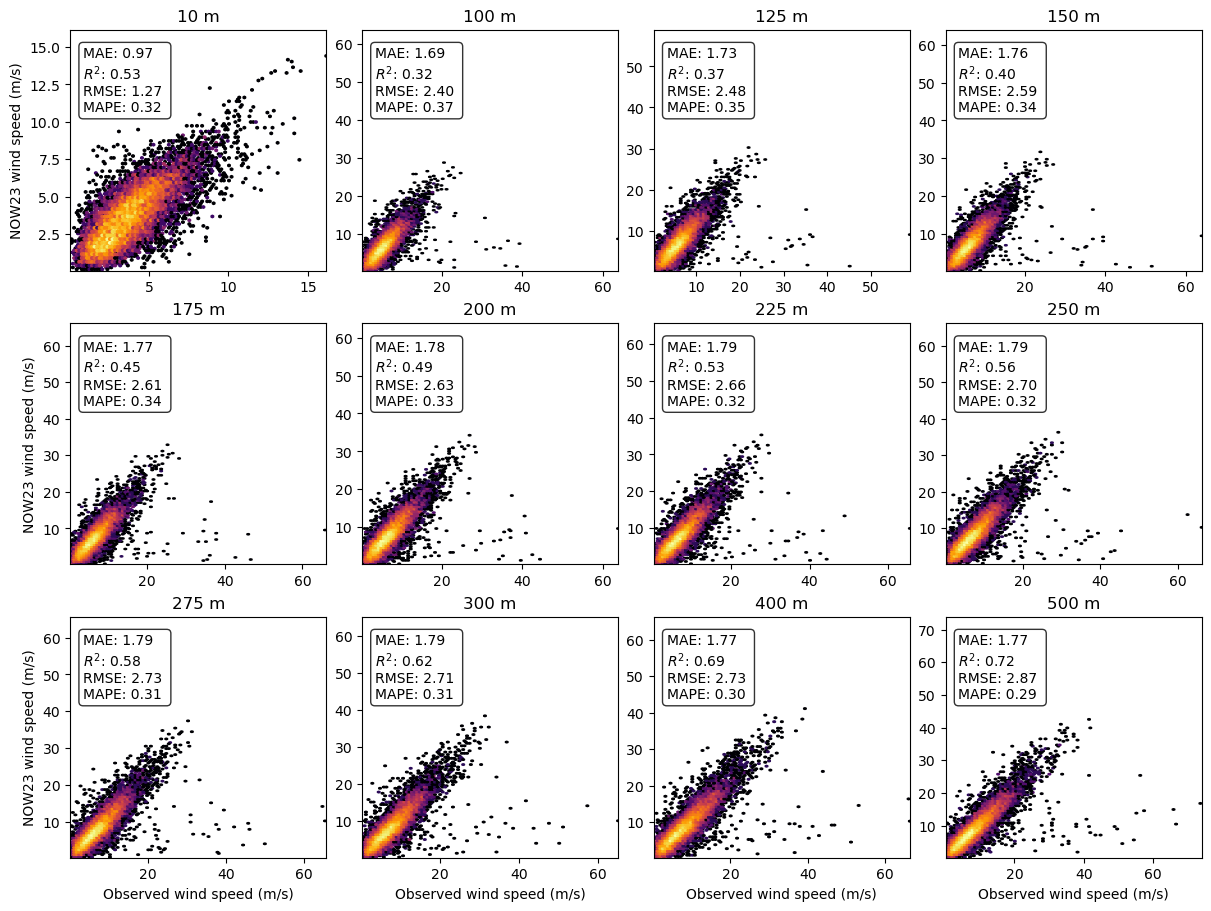

In [45]:
fig = plt.figure(figsize=(12, 9), constrained_layout=True)
gs = fig.add_gridspec(3,4)
for i, level in enumerate(common_levels):
    row = i//4
    col = i%4
    ylabel = 'NOW23 wind speed (m/s)' if col == 0 else ''
    xlabel = 'Observed wind speed (m/s)' if row == 2 else ''
    hexbin_plotter(fig,gs[row,col],common_filtered_profiler_data.sel(range=level),
                common_NOW23_data.sel(height=level),
                f'{level} m',text_arg=True, xlabel=xlabel, ylabel=ylabel)